In [1]:
import pandas as pd 
from utils import DataAnalyzer

In [2]:
train_path = '../data/train_cleaned.csv'
test_path = '../data/test_cleaned.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()
train_df = train_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
test_df = test_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

train_df.head()

,survived,passenger_class,name,gender,age,sibling_spouse_count,parent_child_count,ticket,ticket_fare,cabin,embarked_from,age_range,family_size,cabin_group,winsorized_fare
0,0,third,"braund, mr. owen harris",male,22.0,1,0,a/5 21171,7.2500,NaN,southampton,20-29,1,NaN,7.2500
1,1,first,"cumings, mrs. john bradley (florence briggs th...",female,38.0,1,0,pc 17599,71.2833,c85,cherbourg,30-39,1,c,71.2833
2,1,third,"heikkinen, miss. laina",female,26.0,0,0,ston/o2. 3101282,7.9250,NaN,southampton,20-29,0,NaN,7.9250
3,1,first,"futrelle, mrs. jacques heath (lily may peel)",female,35.0,1,0,113803,53.1000,c123,southampton,30-39,1,c,53.1000
4,0,third,"allen, mr. william henry",male,35.0,0,0,373450,8.0500,NaN,southampton,30-39,0,NaN,8.0500


### Feature Selection

- Drop irrelavant columns 

In [3]:
df = train_df.drop(['name', 'ticket', 'cabin', 'sibling_spouse_count', 'parent_child_count', 'ticket_fare', 'age_range'], axis=1)
df_eval = test_df.drop(['name', 'ticket', 'cabin', 'sibling_spouse_count', 'parent_child_count', 'ticket_fare', 'age_range'], axis=1)

- handle missing data 

In [4]:
DataAnalyzer.get_missing_values(df)

,Total Nulos,% Nulos
cabin_group,687,77.104377
age,177,19.865320
embarked_from,2,0.224467


In [5]:
DataAnalyzer.get_missing_values(df_eval)

,Total Nulos,% Nulos
cabin_group,327,78.229665
age,86,20.574163


- Drop the cabin_group column as 77.10% of the data is missing, and imputing missing values might introduce noise.
- For the age column, fill the missing values with the median age (approximately 29.70 years) based on the age distribution observed during exploratory data analysis.
- For the embarked_port column, fill the two missing values with the mode (the most common port) as it provides a reasonable estimate given the limited number of missing entries.

In [6]:
df.drop(['cabin_group'], axis=1, inplace=True)
df['embarked_from'].fillna(df['embarked_from'].mode()[0], inplace=True)
df['age'].fillna(df['age'].median(), inplace=True)

### Feature Engineering 

- Age Category: Bins the ages into 'Child', 'Teenager', 'Young Adult', 'Adult', and 'Elderly' groups for more generalized analysis.

In [7]:
age_bins = [0, 12, 18, 30, 50, 100]
age_labels = ['child', 'teenager', 'young adult', 'adult', 'elderly']
df['age_category'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)
df_eval['age_category'] = pd.cut(df_eval['age'], bins=age_bins, labels=age_labels, right=False)


- Fare per Family Member: Calculates normalized fare value for each family member based on family size.

In [8]:
df['fare_per_family_member'] = df['winsorized_fare'] / (df['family_size'] + 1)  
df_eval['fare_per_family_member'] = df_eval['winsorized_fare'] / (df_eval['family_size'] + 1)  

In [9]:
## Drop age column as age_category is calculated 
df.drop(['age'], axis=1, inplace=True)
df_eval.drop(['age'], axis=1, inplace=True)

In [10]:
DataAnalyzer.get_missing_values(df)

,Total Nulos,% Nulos


In [11]:
df.head()

,survived,passenger_class,gender,embarked_from,family_size,winsorized_fare,age_category,fare_per_family_member
0,0,third,male,southampton,1,7.2500,young adult,3.62500
1,1,first,female,cherbourg,1,71.2833,adult,35.64165
2,1,third,female,southampton,0,7.9250,young adult,7.92500
3,1,first,female,southampton,1,53.1000,adult,26.55000
4,0,third,male,southampton,0,8.0500,adult,8.05000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   survived                891 non-null    int64   
 1   passenger_class         891 non-null    object  
 2   gender                  891 non-null    object  
 3   embarked_from           891 non-null    object  
 4   family_size             891 non-null    int64   
 5   winsorized_fare         891 non-null    float64 
 6   age_category            891 non-null    category
 7   fare_per_family_member  891 non-null    float64 
dtypes: category(1), float64(2), int64(2), object(3)
memory usage: 49.9+ KB


### Separate Target 

In [13]:
X = df.drop('survived', axis=1)
y = df['survived']

### Train-Test Split

- Stratified sampling is chosen to create the predictive model due to the significant difference in survival rates between male and female passengers, as revealed during exploratory data analysis. This approach ensures proportional representation of both genders in the training and testing datasets, improving model accuracy and generalizability.
- The data will be split in an 80/20 proportion to maintain a balanced representation of male and female passengers in both sets.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, X['gender']):  # Use 'gender' column for stratification
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Now, check the proportions
print("Proportion of males in training set:", (X_train['gender'] == 'male').mean())
print("Proportion of females in training set:", (X_train['gender'] == 'female').mean())

print("Proportion of males in testing set:", (X_test['gender'] == 'male').mean())
print("Proportion of females in testing set:", (X_test['gender'] == 'female').mean())


Proportion of males in training set: 0.6474719101123596
Proportion of females in training set: 0.35252808988764045
Proportion of males in testing set: 0.6480446927374302
Proportion of females in testing set: 0.35195530726256985


In [15]:
class_distribution = y_train.value_counts()

# Calculate the ratio of survived vs. non-survived
survived_ratio = class_distribution[1] / len(y_train)
non_survived_ratio = class_distribution[0] / len(y_train)

print(f'Survived Ratio: {survived_ratio}')
print(f'Non-Survived Ratio: {non_survived_ratio}')

Survived Ratio: 0.3890449438202247
Non-Survived Ratio: 0.6109550561797753


In [16]:
print("Categorical feature distributions:")
print(X_train['gender'].value_counts())
print(X_train['passenger_class'].value_counts())
print(X_train['embarked_from'].value_counts())
print(X_train['age_category'].value_counts())

print("Categorical feature distributions:")
print(X_test['gender'].value_counts())
print(X_test['passenger_class'].value_counts())
print(X_test['embarked_from'].value_counts())
print(X_test['age_category'].value_counts())

Categorical feature distributions:
male      461
female    251
Name: gender, dtype: int64
third     402
first     172
second    138
Name: passenger_class, dtype: int64
southampton    517
cherbourg      132
queenstown      63
Name: embarked_from, dtype: int64
young adult    351
adult          209
elderly         59
child           54
teenager        39
Name: age_category, dtype: int64
Categorical feature distributions:
male      116
female     63
Name: gender, dtype: int64
third     89
second    46
first     44
Name: passenger_class, dtype: int64
southampton    129
cherbourg       36
queenstown      14
Name: embarked_from, dtype: int64
young adult    97
adult          47
elderly        15
child          14
teenager        6
Name: age_category, dtype: int64


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

### Data Transformation

In [18]:
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])


### Build the XGBoost Model

In [20]:
xgb_clf_v1 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

pipeline_v1 = Pipeline([
    ('preprocess', preprocessor),  
    ('classifier', xgb_clf_v1)  
])

pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['family_size', 'winsorized_fare', 'fare_per_family_member'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['passenger_class', 'gender', 'embarked_from', 'age_category'], dtype='object'...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])

In [21]:
pipeline_v1.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns)

array(['passenger_class_first', 'passenger_class_second',
       'passenger_class_third', 'gender_female', 'gender_male',
       'embarked_from_cherbourg', 'embarked_from_queenstown',
       'embarked_from_southampton', 'age_category_adult',
       'age_category_child', 'age_category_elderly',
       'age_category_teenager', 'age_category_young adult'], dtype=object)

### Predictions and Model Baseline Evaluation

In [22]:
y_pred_v1 = pipeline_v1.predict(X_test)

In [23]:
from metrics import ClassificationPlots

plots = ClassificationPlots()
classification_report_str = plots.get_classification_report(y_test, y_pred_v1)
print(classification_report_str)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       114
           1       0.80      0.75      0.78        65

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



### Hyperparameter tunning

In [24]:
xgb_clf_v2 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

pipeline_v2 = Pipeline([
    ('preprocess', preprocessor),  
    ('classifier', xgb_clf_v2) 
])

neg_to_pos_ratio = class_distribution[0] / class_distribution[1]

param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'classifier__max_depth': [3, 5, 7],  
    'classifier__n_estimators': [50, 100, 150, 200],  
    'classifier__scale_pos_weight': [1,2,5] # As there is a disbalanced in the target Survived Ratio: 0.38 and Non-Survived Ratio: 0.61
}

grid_search = GridSearchCV(
    estimator=pipeline_v2,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=5,  
    n_jobs=-1,  
)

grid_search.fit(X_train, y_train) 

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [25]:
best_params

{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 7,
 'classifier__n_estimators': 100,
 'classifier__scale_pos_weight': 1}

In [26]:
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

### Model Performance Metrics

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       114
           1       0.79      0.80      0.79        65

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



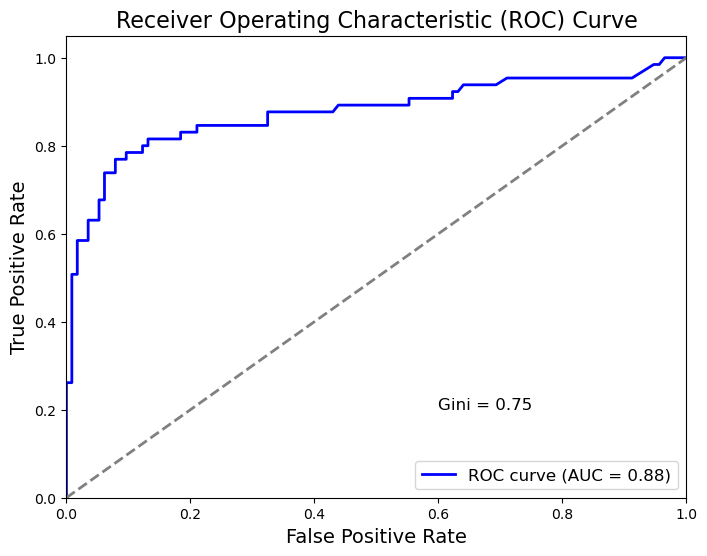

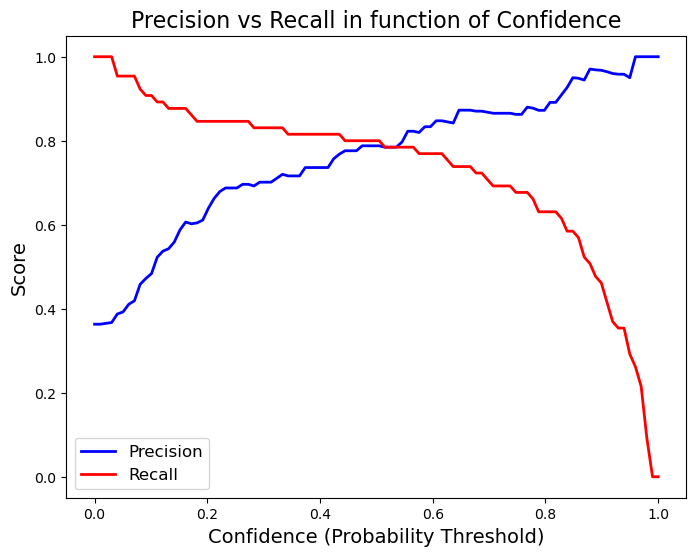

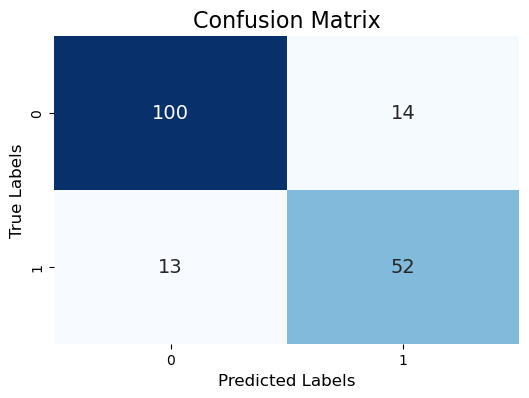

In [27]:
cr = plots.get_classification_report(y_test, y_pred)
print(cr)
plots.plot_roc_curve(y_test, y_pred_prob)
plots.plot_precision_and_recall(y_test, y_pred_prob)
plots.plot_confusion_matrix(y_test, y_pred)

##### Confusion Matrix 
**Positive Class (Class 1): Survived passengers (encoded as 1)**
**Negative Class (Class 0): Non-Survived passengers (encoded as 0)**

- True Positive (TP): 52 passengers correctly predicted as survivors.
- False Positive (FP): 14 passengers falsely predicted as non-survivors.
- True Negative (TN): 100 passengers correctly predicted as non-survivors.
- False Negative (FN): 13 passengers falsely predicted as survivors.

In [28]:
data_with_labels = pd.concat([X_test, y_test], axis=1)

# Separate true labels for males and females
y_true_male = data_with_labels[data_with_labels['gender'] == 'male']['survived']
y_true_female = data_with_labels[data_with_labels['gender'] == 'female']['survived']

In [29]:
gender_mask_male = X_test['gender'] == 'male'
gender_mask_female = X_test['gender'] == 'female'
y_pred_prob = best_model.predict_proba(X_test)

# Separate the predicted probabilities for male and female passengers
y_score_male = y_pred_prob[gender_mask_male, 1]  
y_score_female = y_pred_prob[gender_mask_female, 1]  

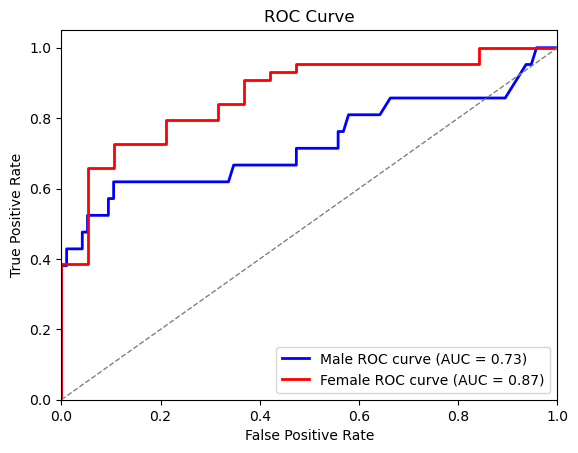

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_male, tpr_male, _ = roc_curve(y_true_male, y_score_male)
fpr_female, tpr_female, _ = roc_curve(y_true_female, y_score_female)

roc_auc_male = auc(fpr_male, tpr_male)
roc_auc_female = auc(fpr_female, tpr_female)

plt.figure()
plt.plot(fpr_male, tpr_male, color='blue', lw=2, label=f'Male ROC curve (AUC = {roc_auc_male:.2f})')
plt.plot(fpr_female, tpr_female, color='red', lw=2, label=f'Female ROC curve (AUC = {roc_auc_female:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Model Performance Metrics Analysis

- The precision for class 0 (non-survivors) is 88%, and for class 1 (survivors) is 80%. This means that when the model predicts a passenger did not survive, it is correct 88% of the time, and when it predicts a passenger survived, it is correct 80% of the time.

- The recall for class 0 is 89%, and for class 1 is 78%. This shows that the model is able to identify 88% of the non-survivors and 78% of the survivors correctly.

- The support column shows that there were 114 non-survivors and 65 survivors in the test dataset.

- As stratified was applied to avoid bias towards the prediction of female survival,  the AUC for fremale is 0.83 and the male is 0.73, the model has a better performance in distringuishing survival for females than males but the difference is not too big. 

- The overal gini value, calculated using the AUC score, is 0.74. This Gini value suggests that the model's predictions are considerably better than random guessing.

- Class imbalance was addressed by using hyperparameters to adjust the weight of the minority class, ensuring that the model does not bias towards the majority class.

### Save Final Model and  Data Transformer

In [31]:
import pickle
import joblib

with open('../api/model/survival_predictor.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [32]:
## Save the transformation to apply to other datasets in order to keep consistency in the data and being able to reproduce among other reasons. 
joblib.dump(pipeline_v2.named_steps['preprocess'].named_transformers_['num'].named_steps['scaler'], '../api/model/minmax_scaler.pkl')
joblib.dump(pipeline_v2.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'], '../api/model/onehot.pkl')

['../api/model/onehot.pkl']